# Temat: Pali się

https://www.kaggle.com/datasets/gatandubuc/public-transport-traffic-data-in-france

## Cel -> wykrycie sytuacji w której pożar zagraża ludziom

## Stakeholder -> straż pożarna pracująca nad systemem wczesnego ostrzegania oraz reagowania na zagrożenia pożarowe



#### Doczytać o niezbilansowanych zbiorach danych
#### [przegląd różnych metod]
#### Test - zbudować model bez żadnego bilansowania
#### Benchmark - zrobienie minimum i zbudowanie modelu benchmarkowego [usunięcie braków, zamiana zmiennych kategorycznych]
#### Zmienne kategoryczne - zacząć od label encodingu AS-IS, w drugiej kolejności ewentualnie zrobić grupowanie

#### Import bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc 

import Functions_ML as my_functions

%matplotlib inline

In [2]:
df = pd.read_csv('Fire-Incidents.csv')

pd.set_option('display.max_columns', None)

### Usunięcie niepotrzebnych kolumn

In [3]:
col_to_drop = ['Business_Impact', 'Estimated_Dollar_Loss', 'Estimated_Number_Of_Persons_Displaced',
                'Ext_agent_app_or_defer_time', 'Last_TFS_Unit_Clear_Time']

df = df.drop(columns = col_to_drop, axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11214 entries, 0 to 11213
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Area_of_Origin                            11214 non-null  object 
 1   Civilian_Casualties                       11214 non-null  int64  
 2   Count_of_Persons_Rescued                  11214 non-null  int64  
 3   Extent_Of_Fire                            11214 non-null  object 
 4   Fire_Alarm_System_Impact_on_Evacuation    11214 non-null  object 
 5   Fire_Alarm_System_Operation               11214 non-null  object 
 6   Fire_Alarm_System_Presence                11214 non-null  object 
 7   Fire_Under_Control_Time                   11214 non-null  object 
 8   Ignition_Source                           11214 non-null  object 
 9   Incident_Station_Area                     11214 non-null  int64  
 10  Incident_Ward                     

### Remove empty rows

In [4]:
df.isna().sum()

Area_of_Origin                               0
Civilian_Casualties                          0
Count_of_Persons_Rescued                     0
Extent_Of_Fire                               0
Fire_Alarm_System_Impact_on_Evacuation       0
Fire_Alarm_System_Operation                  0
Fire_Alarm_System_Presence                   0
Fire_Under_Control_Time                      0
Ignition_Source                              0
Incident_Station_Area                        0
Incident_Ward                               33
Latitude                                     0
Longitude                                    0
Material_First_Ignited                       0
Method_Of_Fire_Control                       0
Possible_Cause                               0
Property_Use                                 0
Smoke_Alarm_at_Fire_Origin_Alarm_Failure     0
Smoke_Alarm_at_Fire_Origin_Alarm_Type        0
Status_of_Fire_On_Arrival                    0
TFS_Alarm_Time                               0
TFS_Arrival_T

In [5]:
df.dropna(inplace = True)

### Change data type to datetime

In [6]:
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 11213
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Area_of_Origin                            11181 non-null  object        
 1   Civilian_Casualties                       11181 non-null  int64         
 2   Count_of_Persons_Rescued                  11181 non-null  int64         
 3   Extent_Of_Fire                            11181 non-null  object        
 4   Fire_Alarm_System_Impact_on_Evacuation    11181 non-null  object        
 5   Fire_Alarm_System_Operation               11181 non-null  object        
 6   Fire_Alarm_System_Presence                11181 non-null  object        
 7   Fire_Under_Control_Time                   11181 non-null  object        
 8   Ignition_Source                           11181 non-null  object        
 9   Incident_Station_Area            

### Civilian_Casualties -> Y 
#### Civilian_Casualties, if value >= 1 set 1

In [8]:
df.loc[df['Civilian_Casualties'] >= 1, 'Civilian_Casualties'] = 1

In [9]:
df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time
0,Porch or Balcony,0,86,Confined to object of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,Undetermined,114,18.0,43.760357,-79.412479,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Fire with smoke showing only - including vehic...,2018-08-24 16:49:36,2018-08-24 16:54:09
1,Cooking Area or Kitchen,0,28,Confined to part of room/area of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,"Other Cooking Items (eg Toaster, Kettle, elec ...",142,7.0,43.754542,-79.530419,Plastic,Extinguished by occupant,Under Investigation,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire extinguished prior to arrival,2018-11-24 07:09:12,2018-11-24 07:14:23
2,"Living Area (e.g. living, TV, recreation, etc)",1,16,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,Undetermined,325,27.0,43.657300,-79.373460,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Flames showing from small area (one storey or ...,2017-02-09 17:45:07,2017-02-09 17:48:49
3,Undetermined (formerly 98),0,12,Entire Structure,Undetermined,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,Undetermined,332,20.0,43.649350,-79.393700,Undetermined (formerly 98),Extinguished by fire department,Undetermined,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,Flames showing from large area (more than one ...,2012-10-30 00:42:01,2012-10-30 00:44:58
4,"Sleeping Area or Bedroom (inc. patients room, ...",1,11,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,Matches or Lighters (unable to distinguish),442,5.0,43.697960,-79.511539,Bedding,Extinguished by fire department,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire with no evidence from street,2018-07-08 04:08:50,2018-07-08 04:13:54


In [10]:
df['Civilian_Casualties'].value_counts()

Civilian_Casualties
0    10233
1      948
Name: count, dtype: int64

In [11]:
df['Property_Use'].value_counts().head(25)

Property_Use
Multi-Unit Dwelling - Over 12 Units                              3716
Detached Dwelling                                                2309
Semi-Detached Dwelling                                            727
Attached Dwelling (eg. rowhouse, townhouse, etc.)                 577
Multi-Unit Dwelling - 2 to 6 Units                                279
Apartment, Flat, Tenement with Business                           276
Restaurants (occupant load greater than 30 persons, licensed)     229
Restaurant (occupant load less than 30 persons)                   164
Multi-Unit Dwelling - 7 to 12 Units                               145
Detached Garage                                                   134
Subway Station                                                    131
Rooming/Boarding/Lodging House                                    121
General Business Office                                           119
Motor Vehicle Repair Garage                                       113
Other B

### Calculating the time when the fire brigade arrived

In [12]:
df['Response'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']) / pd.Timedelta(minutes = 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 11213
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Area_of_Origin                            11181 non-null  object        
 1   Civilian_Casualties                       11181 non-null  int64         
 2   Count_of_Persons_Rescued                  11181 non-null  int64         
 3   Extent_Of_Fire                            11181 non-null  object        
 4   Fire_Alarm_System_Impact_on_Evacuation    11181 non-null  object        
 5   Fire_Alarm_System_Operation               11181 non-null  object        
 6   Fire_Alarm_System_Presence                11181 non-null  object        
 7   Fire_Under_Control_Time                   11181 non-null  object        
 8   Ignition_Source                           11181 non-null  object        
 9   Incident_Station_Area            

### Set 'Property_use' string value 'Business' or 'Non-Business' based on Dwelling

In [14]:
df['Property_Use_Category'] = df['Property_Use'].apply(my_functions.classification)

In [15]:
df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Property_Use_Category
0,Porch or Balcony,0,86,Confined to object of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,Undetermined,114,18.0,43.760357,-79.412479,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Fire with smoke showing only - including vehic...,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,Business
1,Cooking Area or Kitchen,0,28,Confined to part of room/area of origin,Not applicable: Occupant(s) first alerted by o...,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,"Other Cooking Items (eg Toaster, Kettle, elec ...",142,7.0,43.754542,-79.530419,Plastic,Extinguished by occupant,Under Investigation,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire extinguished prior to arrival,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,Non-Business
2,"Living Area (e.g. living, TV, recreation, etc)",1,16,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,Undetermined,325,27.0,43.657300,-79.373460,Undetermined (formerly 98),Extinguished by fire department,Undetermined,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),Flames showing from small area (one storey or ...,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,Business
3,Undetermined (formerly 98),0,12,Entire Structure,Undetermined,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,Undetermined,332,20.0,43.649350,-79.393700,Undetermined (formerly 98),Extinguished by fire department,Undetermined,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,Flames showing from large area (more than one ...,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,Non-Business
4,"Sleeping Area or Bedroom (inc. patients room, ...",1,11,"Spread beyond room of origin, same floor",Some persons (at risk) evacuated as a result o...,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,Matches or Lighters (unable to distinguish),442,5.0,43.697960,-79.511539,Bedding,Extinguished by fire department,Suspected Arson,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,Fire with no evidence from street,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,Business


### Encode string columns to number

In [16]:
label_encoder = LabelEncoder()

def encode(columns_encode):
    for col in columns_encode:
        df[col] = label_encoder.fit_transform(df[col])
    return df


In [17]:
columns_encode = ['Area_of_Origin', 'Extent_Of_Fire', 'Fire_Alarm_System_Impact_on_Evacuation',
                 'Ignition_Source', 'Material_First_Ignited', 'Method_Of_Fire_Control', 'Possible_Cause', 'Status_of_Fire_On_Arrival']

In [18]:
encode(columns_encode)

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Property_Use_Category
0,51,0,86,0,4,Fire alarm system did not operate,Fire alarm system present,2018-08-24T17:06:28,75,114,18.0,43.760357,-79.412479,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),3,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,Business
1,11,0,28,1,4,Fire alarm system operated,Fire alarm system present,2018-11-24T07:19:00,48,142,7.0,43.754542,-79.530419,41,3,18,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,Non-Business
2,31,1,16,8,5,Fire alarm system operated,Fire alarm system present,2017-02-09T18:36:21,75,325,27.0,43.657300,-79.373460,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),5,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,Business
3,70,0,12,3,6,Fire alarm system operation undetermined,Undetermined,2012-10-30T01:28:48,75,332,20.0,43.649350,-79.393700,49,2,19,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,4,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,Non-Business
4,62,1,11,8,5,Fire alarm system operated,Fire alarm system present,2018-07-08T04:38:28,40,442,5.0,43.697960,-79.511539,4,2,14,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,2,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,Business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11209,66,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-23T14:50:16,75,313,13.0,43.667295,-79.373778,45,1,6,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),2,2018-02-23 14:35:03,2018-02-23 14:38:33,3.500000,Business
11210,45,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-24T02:04:10,12,222,20.0,43.729364,-79.280725,49,3,2,General Business Office,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-02-24 01:30:45,2018-02-24 01:36:59,6.233333,Non-Business
11211,45,0,0,0,0,Fire alarm system operated,Fire alarm system present,2018-02-24T02:40:00,10,222,20.0,43.729364,-79.280725,14,3,10,General Business Office,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-02-24 02:30:33,2018-02-24 02:35:07,4.566667,Non-Business
11212,51,1,0,1,0,Fire alarm system operated,Fire alarm system present,2018-02-24T00:48:11,65,141,7.0,43.763361,-79.500863,40,2,6,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Battery operated,5,2018-02-24 00:34:12,2018-02-24 00:38:47,4.583333,Business


### Encoding chosen Fire alarm columns to binary values 

In [19]:
df = pd.get_dummies(df, columns = ['Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 'Property_Use_Category'])

df.head()

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Fire_Under_Control_Time,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Status_of_Fire_On_Arrival,TFS_Alarm_Time,TFS_Arrival_Time,Response,Fire_Alarm_System_Operation_Fire alarm system did not operate,Fire_Alarm_System_Operation_Fire alarm system operated,Fire_Alarm_System_Operation_Fire alarm system operation undetermined,Fire_Alarm_System_Operation_Not applicable (no system),Fire_Alarm_System_Presence_Fire alarm system present,Fire_Alarm_System_Presence_No Fire alarm system,Fire_Alarm_System_Presence_Not applicable (bldg not classified by OBC OR detached/semi/town home),Fire_Alarm_System_Presence_Undetermined,Property_Use_Category_Business,Property_Use_Category_Non-Business
0,51,0,86,0,4,2018-08-24T17:06:28,75,114,18.0,43.760357,-79.412479,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),3,2018-08-24 16:49:36,2018-08-24 16:54:09,4.550000,True,False,False,False,True,False,False,False,True,False
1,11,0,28,1,4,2018-11-24T07:19:00,48,142,7.0,43.754542,-79.530419,41,3,18,Infirmary,Not applicable: Alarm operated OR presence/ope...,Interconnected,1,2018-11-24 07:09:12,2018-11-24 07:14:23,5.183333,False,True,False,False,True,False,False,False,False,True
2,31,1,16,8,5,2017-02-09T18:36:21,75,325,27.0,43.657300,-79.373460,49,2,19,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Hardwired (standalone),5,2017-02-09 17:45:07,2017-02-09 17:48:49,3.700000,False,True,False,False,True,False,False,False,True,False
3,70,0,12,3,6,2012-10-30T01:28:48,75,332,20.0,43.649350,-79.393700,49,2,19,"Clothing Store, Accessories, fur",Not applicable: Alarm operated OR presence/ope...,Type undetermined,4,2012-10-30 00:42:01,2012-10-30 00:44:58,2.950000,False,False,True,False,False,False,False,True,False,True
4,62,1,11,8,5,2018-07-08T04:38:28,40,442,5.0,43.697960,-79.511539,4,2,14,Multi-Unit Dwelling - Over 12 Units,Not applicable: Alarm operated OR presence/ope...,Interconnected,2,2018-07-08 04:08:50,2018-07-08 04:13:54,5.066667,False,True,False,False,True,False,False,False,True,False


### Prepare to create model

In [20]:
df_two = df.copy()

In [21]:
df_two['Fire_Alarm_System_Presence_No Fire alarm system'].value_counts()

Fire_Alarm_System_Presence_No Fire alarm system
False    9393
True     1788
Name: count, dtype: int64

In [22]:
col_to_drop = ['Fire_Under_Control_Time', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'TFS_Alarm_Time', 'TFS_Arrival_Time']


In [23]:
df_two.drop(columns = col_to_drop, inplace = True)

In [24]:
df_two.sample(10)

,Area_of_Origin,Civilian_Casualties,Count_of_Persons_Rescued,Extent_Of_Fire,Fire_Alarm_System_Impact_on_Evacuation,Ignition_Source,Incident_Station_Area,Incident_Ward,Latitude,Longitude,Material_First_Ignited,Method_Of_Fire_Control,Possible_Cause,Status_of_Fire_On_Arrival,Response,Fire_Alarm_System_Operation_Fire alarm system did not operate,Fire_Alarm_System_Operation_Fire alarm system operated,Fire_Alarm_System_Operation_Fire alarm system operation undetermined,Fire_Alarm_System_Operation_Not applicable (no system),Fire_Alarm_System_Presence_Fire alarm system present,Fire_Alarm_System_Presence_No Fire alarm system,Fire_Alarm_System_Presence_Not applicable (bldg not classified by OBC OR detached/semi/town home),Fire_Alarm_System_Presence_Undetermined,Property_Use_Category_Business,Property_Use_Category_Non-Business
839,11,0,0,0,6,69,325,13.0,43.658171,-79.372390,10,3,17,1,4.216667,False,True,False,False,True,False,False,False,True,False
10651,11,0,0,1,3,69,421,12.0,43.687530,-79.476230,10,3,17,1,5.900000,False,False,False,True,False,True,False,False,True,False
292,11,0,1,1,2,57,225,36.0,43.697550,-79.256790,31,2,17,2,5.216667,False,True,False,False,True,False,False,False,True,False
3922,25,0,0,0,6,77,441,4.0,43.695800,-79.552160,51,2,19,3,5.000000,False,True,False,False,True,False,False,False,True,False
3956,11,0,0,0,0,69,426,14.0,43.639950,-79.439860,5,3,5,2,5.083333,False,True,False,False,True,False,False,False,True,False
3929,57,0,0,0,4,1,114,23.0,43.768880,-79.401740,16,3,9,3,6.216667,True,False,False,False,True,False,False,False,True,False
8937,51,0,0,0,6,65,313,27.0,43.670940,-79.378880,45,3,5,1,3.983333,False,True,False,False,True,False,False,False,True,False
11189,66,0,0,0,6,65,344,20.0,43.665510,-79.403110,45,1,6,1,4.433333,False,True,False,False,True,False,False,False,True,False
11005,72,0,0,1,0,1,142,8.0,43.766040,-79.511670,21,3,10,1,3.066667,False,True,False,False,True,False,False,False,True,False
2171,25,0,0,7,3,75,241,22.0,43.818129,-79.322218,49,2,19,4,5.083333,False,False,False,True,False,False,True,False,True,False


## Assign 'Civilian_Casualties' to y

In [25]:
X = df_two.drop(columns = 'Civilian_Casualties')
y = df_two['Civilian_Casualties']

## Split into training and test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

### Skalowanie, zapewnienie stabilności numerycznej i szybszej konwergencji algorytmów opytmalizacyjnych

In [27]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Create Model

In [28]:
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### accuracy_score_ and classification_report

In [29]:
y_pred = model.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9222172552525704

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2050
           1       0.64      0.16      0.25       187

    accuracy                           0.92      2237
   macro avg       0.79      0.57      0.60      2237
weighted avg       0.90      0.92      0.90      2237



In [30]:
print(confusion_matrix(y_test, y_pred))

[[2034   16]
 [ 158   29]]


In [31]:
pred_train = model.predict_proba(X_train)

C:\Users\marci\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [32]:
pred_train

array([[0.74, 0.26],
       [0.73, 0.27],
       [0.73, 0.27],
       ...,
       [0.7 , 0.3 ],
       [0.67, 0.33],
       [0.76, 0.24]])

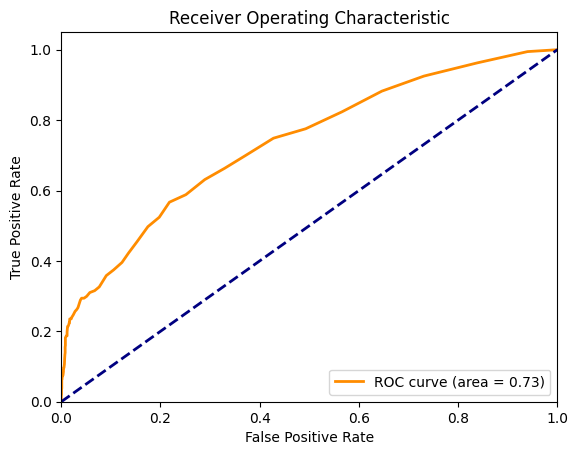

In [33]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Obliczanie wartości FPR, TPR oraz progu
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Rysowanie krzywej ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_prob)

ValueError: Mix type of y not allowed, got types {'binary', 'continuous'}